# Setup

In [189]:
import os
import subprocess
import sys
import warnings

warnings.filterwarnings("ignore")

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "neuralgeom"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

Working directory:  /home/facosta/neuralgeom/neuralgeom
Directory added to path:  /home/facosta/neuralgeom
Directory added to path:  /home/facosta/neuralgeom/neuralgeom


# Imports

In [190]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [191]:
import json

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

import default_config as config
import neuralgeom.datasets.utils as utils
import neuralgeom.models.neural_vae as neural_vae
import train
import viz

# Get config for the run of interest

## Specify run ID

In [192]:
#run_id = "9a727e13"
run_id ="35a83a2d"

#run_id = "aa47d16b"

## Load run config

In [193]:
CONFIG_DIR = os.path.join(os.getcwd(), "results", "configs")

print(f"Config in directory: {CONFIG_DIR}:")
for config_file in os.listdir(CONFIG_DIR):
    if run_id in config_file:
        print(config_file)
        run_id_config_file = config_file

with open(
    os.path.join(CONFIG_DIR, run_id_config_file),
    "r",
) as f:
    config_dict = json.load(f)

# Convert a dict into an object where attributes are accessed with "."
# This is needed for the utils.load() function
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


config = AttrDict(config_dict)
config;

Config in directory: /home/facosta/neuralgeom/neuralgeom/results/configs:
run_35a83a2d_s1_synthetic_noise_var_0.001_embedding_dim_3.json


# Get data & model

## Load data

In [194]:
dataset_torch, labels, train_loader, test_loader = utils.load(config)
dataset_torch = dataset_torch.to(config.device)
_, data_dim = dataset_torch.shape

Dataset shape: torch.Size([2000, 3]).


## Load model

In [195]:
trained_models_dir = os.path.join(os.getcwd() + "/results/trained_models")

model_path = os.path.join(trained_models_dir, f"{config.results_prefix}_model.pt")
model = torch.load(model_path)

## Get learned immersion $f$ and neural metric

In [196]:
import geomstats.backend as gs
from geomstats.geometry.pullback_metric import PullbackMetric

import evaluate

learned_immersion = evaluate.get_learned_immersion(model, config)

neural_metric = PullbackMetric(
    dim=1, embedding_dim=config.data_dim, immersion=learned_immersion
)

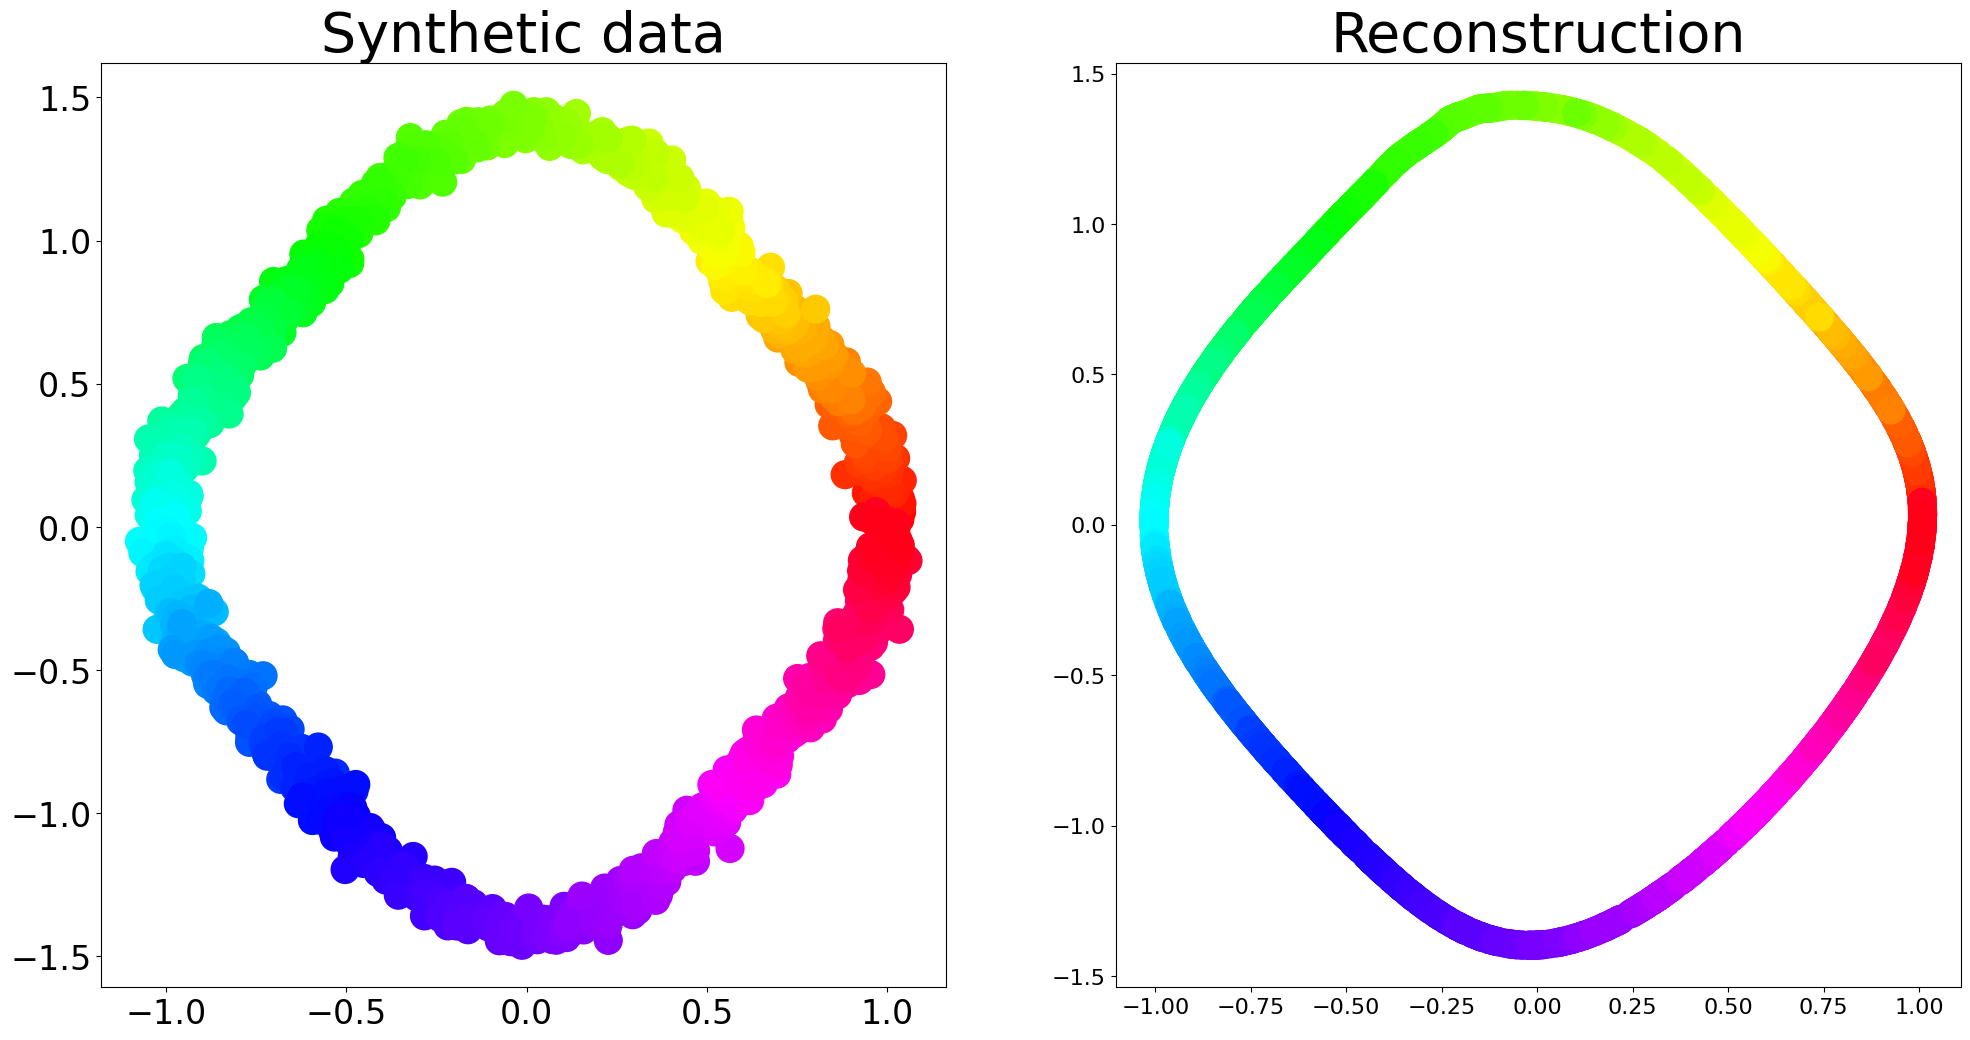

In [197]:
viz.plot_recon_per_positional_angle(model, dataset_torch, labels, config);

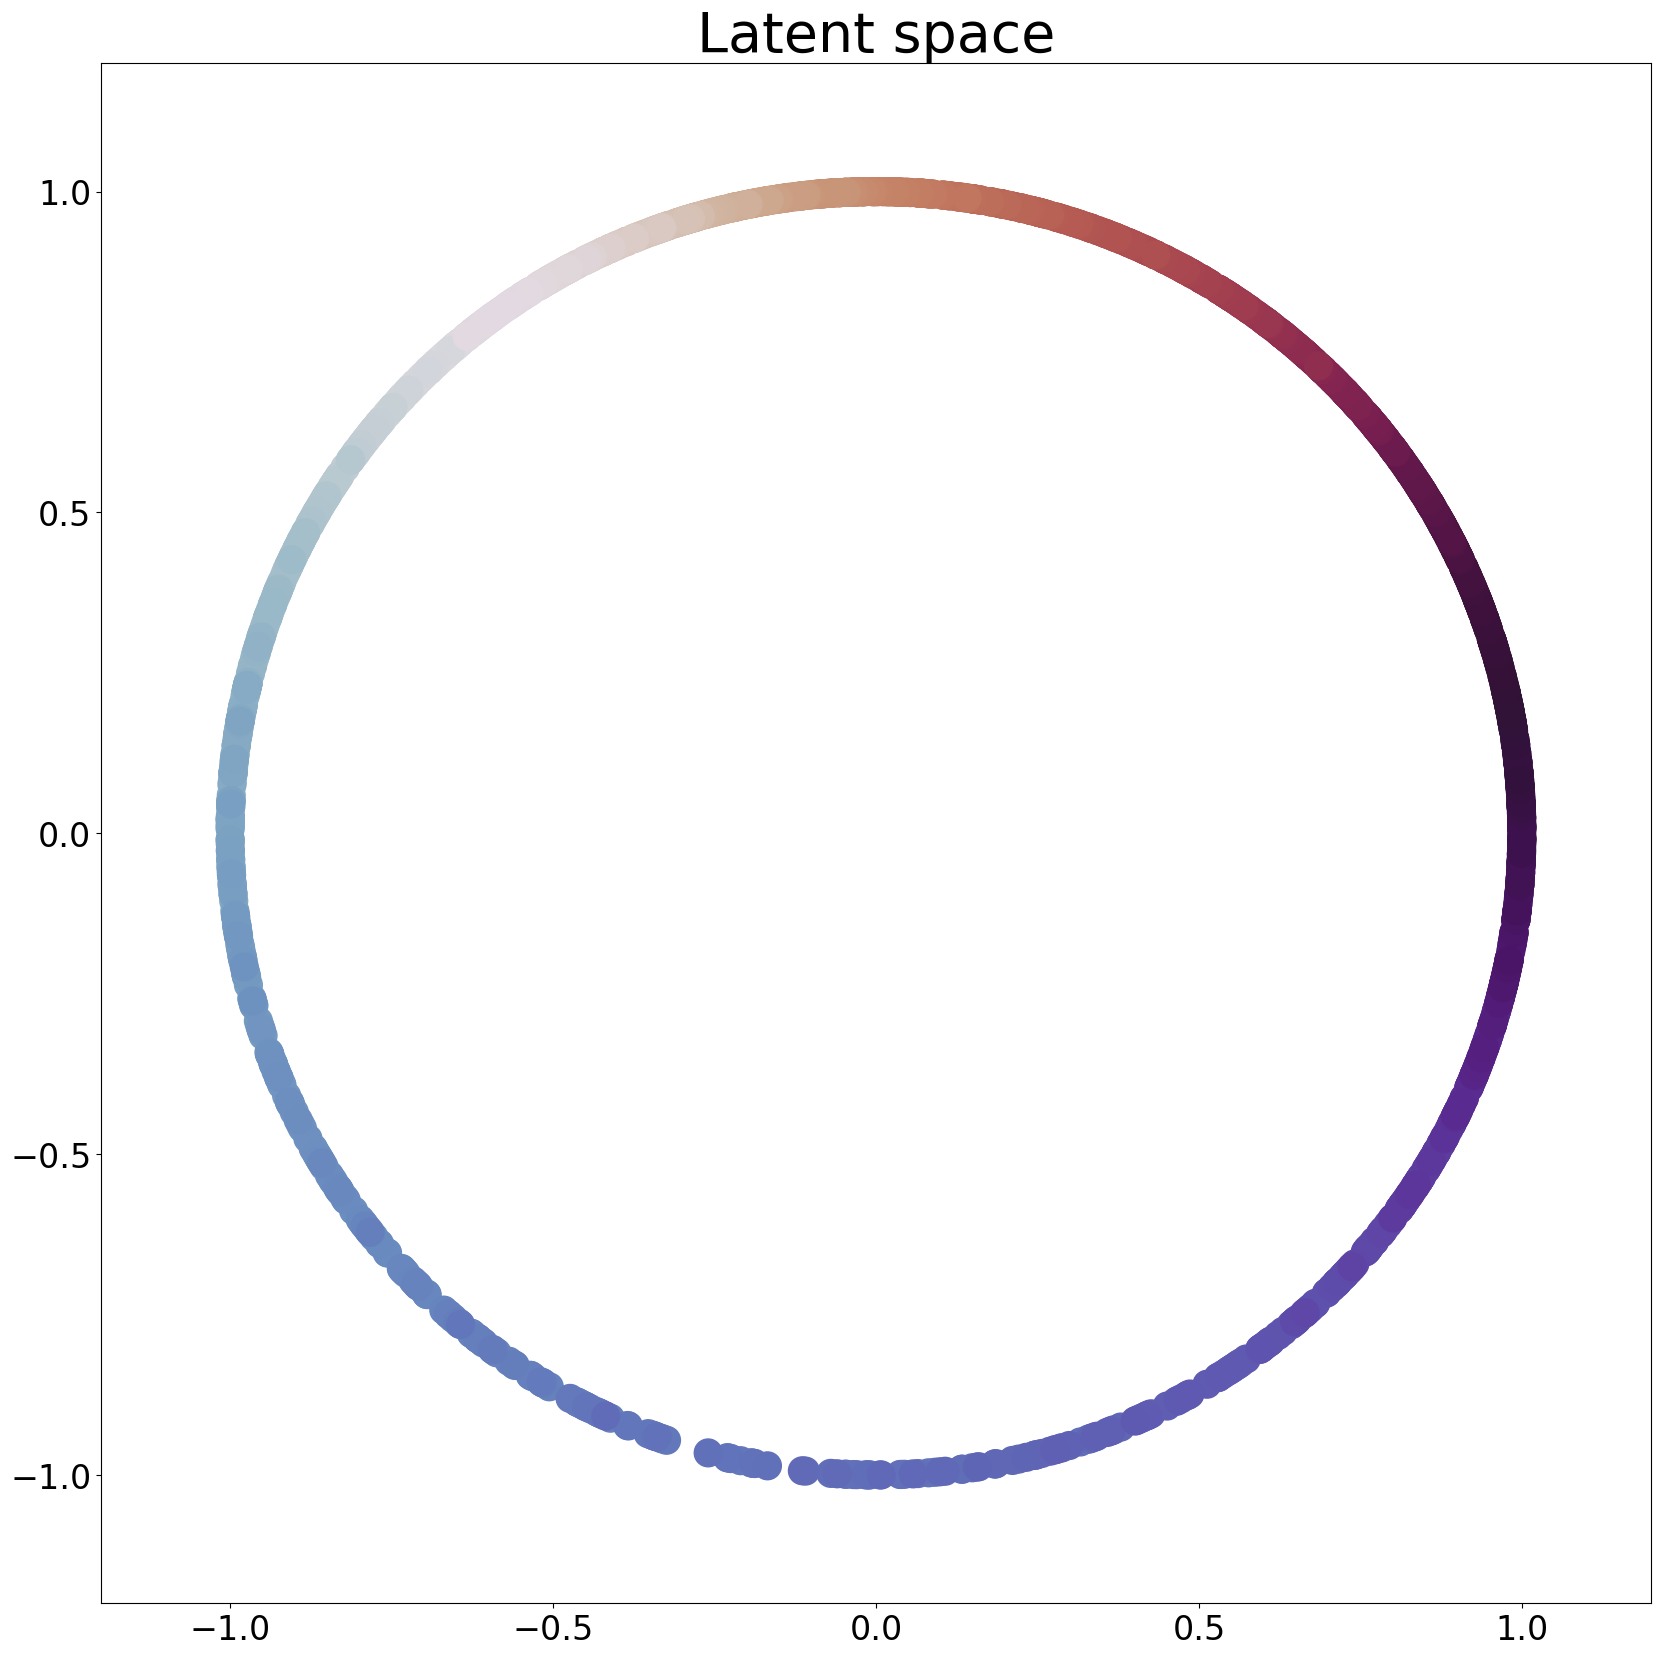

In [198]:
viz.plot_latent_space(model, dataset_torch, labels, config);

# Towards parameterization invariance

## Compute true curvature

In [199]:
true_immersion= evaluate.get_true_immersion(config)
z_grid_true, geodesic_dist_true, curv_true, curv_norm_true = evaluate.compute_curvature_true(config,100)

Computation time: 1.166 seconds.


## Compute learned curvature

In [200]:
z_grid, geodesic_dist, curv, curv_norm = evaluate.compute_curvature_learned(model, config, embedding_dim = 3, n_grid_points=100)

Computation time: 6.519 seconds.


## Parallel computations of geodesic distances

In [201]:
import time
import copy
import logging

from joblib import Parallel, delayed

model.to("cuda:0")
# z_grid = torch.tensor(curv_norm_learned_profile["z_grid"].values)
z0 = torch.unsqueeze(z_grid[0], dim=0)


# TODO (use logging to actually print and know which iterations we are on)
def _geodesic_dist(i_z, z, grid_interval):
    if i_z == 0:
        return (0, torch.tensor(0.0))
    # Parallelize on gpus: is that line really helping,
    # i.e. is the copy taking less time than the computation? if not, don't bother
    # also: does it change anything since neural metric has already been computed and uses the old version of model?
    model_copy = copy.deepcopy(model).to(f"cuda:{i_z % 9}")
    z = torch.unsqueeze(z, dim=0)
    z_previous = torch.unsqueeze(z_grid[i_z - grid_interval], dim=0)
    start = time.time()
    # Tricks to speed up this computation:
    # 1. Compute with less number of steps for the integration of the geodesic eqn
    # 2. Compute distance between neighboring z's
    dist = neural_metric.dist(z_previous, z, n_steps=10)
    duration = time.time() - start
    logging.info(f"Time (it: {i_z}): {duration:.3f}")
    return (i_z, dist)


# To try this code , use z_grid[:5] to run on smaller batch
# Currently, the z_grid is too big (~800) --> go to 100
# Note: each distance computation takes ~5s.
grid_interval = 1
res = Parallel(n_jobs=-1)(
    delayed(_geodesic_dist)(i_z, z, grid_interval)
    for i_z, z in enumerate(z_grid)
    if i_z % grid_interval == 0
)

INFO: Time (it: 9): 1.360
INFO: Time (it: 32): 1.864
INFO: Time (it: 1): 2.164
INFO: Time (it: 2): 2.201
INFO: Time (it: 5): 2.311
INFO: Time (it: 10): 2.458
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Time (it: 33): 2.329
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Time (it: 18): 3.903
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Time (it: 27): 4.200
INFO:

In [202]:
geodesic_dists = torch.zeros(len(res))
curv_norms = torch.zeros(len(res))
curv_series = pd.Series(curv_norm.numpy())
for i_z, dist in res:
    geodesic_dists[i_z] = dist
    curv_norms[i_z] = curv_series.values[i_z]
    
cumul_geodesic_dists = torch.cumsum(geodesic_dists, dim=0)

In [203]:
def remove_outliers(x1,x2,y):
    threshold = 10*np.median(y)
    x1 = x1[y < threshold]
    x2 = x2[y < threshold]
    y = y[y < threshold]
    
    return x1, x2, y

In [204]:
if isinstance(curv_norms, torch.Tensor):
    curv_norms = curv_norms.numpy()
if isinstance(curv_norm_true, torch.Tensor):
    curv_norm_true = curv_norm_true.numpy()

# Plot grid vs geodesic vs true

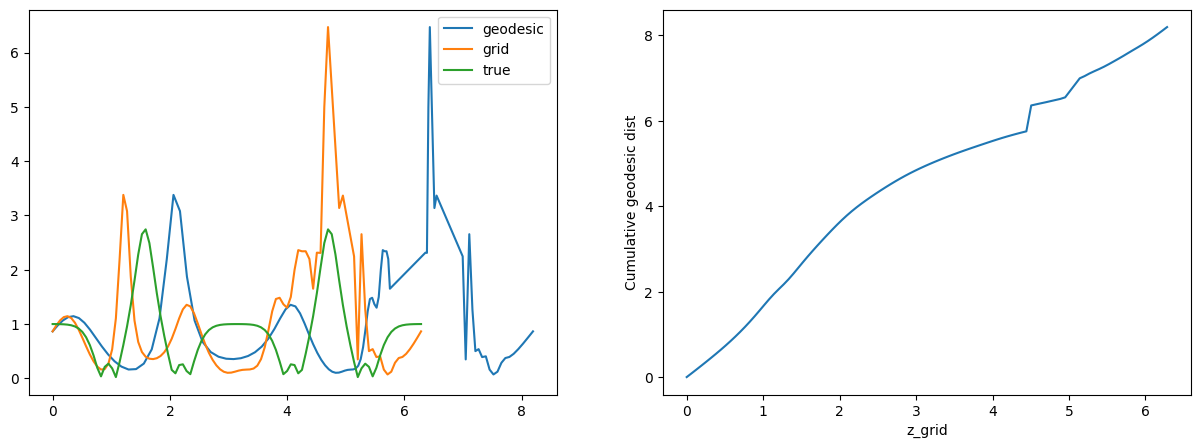

In [205]:
z_grid, cumul_geodesic_dists, curv_norms = remove_outliers(z_grid, cumul_geodesic_dists, curv_norms)

fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(122)
ax1.plot(z_grid,cumul_geodesic_dists)
ax1.set_xlabel("z_grid")
ax1.set_ylabel("Cumulative geodesic dist")


ax2 = fig.add_subplot(121)
ax2.plot(cumul_geodesic_dists,curv_norms,label="geodesic")
ax2.plot(z_grid,curv_norms,label = "grid")
ax2.plot(z_grid_true,curv_norm_true, label = "true")
ax2.legend()